In [6]:
import pandas as pd

df = pd.read_csv('/content/gojek_scraper_ulasan_app.csv')
df.head()

,Review ID,Username,Rating,Review Text,Date
0,ab702a1a-0183-4c69-a07d-c1e49024ec58,Pengguna Google,1,"cs nya susah mau aduin komplain, ga simple ban...",2025-10-01 11:56:31
1,6fcfee32-8878-4ccb-8bea-7e564ab30b56,Pengguna Google,2,lumayan,2025-10-01 11:47:47
2,4eab9334-86da-44de-ab3a-8fe6c88dac27,Pengguna Google,5,bagus,2025-10-01 11:45:58
3,520ed184-0cc1-44fa-a0fa-e8bd03731958,Pengguna Google,5,mantap,2025-10-01 11:41:12
4,319f0a10-4e83-4540-b127-8c97a2022cc7,Pengguna Google,5,nice,2025-10-01 11:30:14


In [7]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 11.7 MB/s eta 0:00:00


In [8]:
import re
import nltk
from nltk.tokenize import word_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Pastikan resource ada
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [9]:
# Stopword remover
stop_factory = StopWordRemoverFactory()
stopwords = set(stop_factory.get_stop_words())

# Stemmer
stemmer = StemmerFactory().create_stemmer()

In [10]:
# 1. Case Folding
df['case_folding'] = df['Review Text'].astype(str).str.lower()
df['case_folding'] = df['case_folding'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

In [11]:
# 2. Tokenizing
df['tokenizing'] = df['case_folding'].apply(lambda x: word_tokenize(x))

In [12]:
# 3. Filtering (hapus stopwords)
df['filtering'] = df['tokenizing'].apply(lambda tokens: [w for w in tokens if w not in stopwords])

In [13]:
# Gabungkan hasil stemming jadi kalimat akhir
df['clean_review'] = df['filtering'].apply(lambda tokens: " ".join(tokens))

In [14]:
df['clean_review'].head(5000)

,clean_review
0,cs nya susah mau aduin komplain ga simple bang...
1,lumayan
2,bagus
3,mantap
4,nice
...,...
4995,mantab cepat murah
4996,banyak promo nya
4997,tetap grab terbaik
4998,hari pengalaman terburuk hari omelin driver go...


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Ambil teks bersih
corpus = df['clean_review'].astype(str)

# Inisialisasi TF-IDF (unigram + bigram supaya lebih kaya fitur)
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5)

# Fit dan transform
tfidf_matrix = vectorizer.fit_transform(corpus)

# Cek ukuran matrix
print("TF-IDF matrix shape:", tfidf_matrix.shape)

# Lihat 20 fitur pertama
print(vectorizer.get_feature_names_out()[:10])

TF-IDF matrix shape: (20000, 5327)
['aamiin' 'abang' 'abang gojek' 'abangnya' 'abis' 'ac' 'acara' 'acc'
 'aceng' 'ad']


In [16]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np # Import numpy

count_vectorizer = CountVectorizer(ngram_range=(1,2), min_df=5)
count_matrix = count_vectorizer.fit_transform(corpus)

# Hitung frekuensi total
word_counts = np.array(count_matrix.sum(axis=0)).flatten()

word_freq = pd.DataFrame({
    'kata': count_vectorizer.get_feature_names_out(),
    'frekuensi': word_counts
}).sort_values(by='frekuensi', ascending=False)

print(word_freq.head(10))

          kata  frekuensi
1185    driver       3036
1614     gojek       3027
3439       nya       2391
4279    sangat       2277
212   aplikasi       2011
5264        yg       1705
1381        ga       1586
331      bagus       1582
2985  membantu       1515
2835    mantap       1371


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Create 'Sentimen_Biner' column based on 'Rating'
df['Sentimen_Biner'] = df['Rating'].apply(lambda x: 1 if x >= 4 else 0)

# Ambil fitur (TF-IDF) dan target (label sentimen)
X = tfidf_matrix
y = df['Sentimen_Biner'] # use the new column

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Model klasifikasi (contoh Logistic Regression)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Prediksi
y_pred = clf.predict(X_test)

# Evaluasi
print("Akurasi:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["Negatif", "Positif"]))

Akurasi: 0.914
              precision    recall  f1-score   support

     Negatif       0.87      0.82      0.85      1160
     Positif       0.93      0.95      0.94      2840

    accuracy                           0.91      4000
   macro avg       0.90      0.89      0.89      4000
weighted avg       0.91      0.91      0.91      4000



/tmp/ipython-input-3117032654.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=predicted_sentiment_df['Prediksi_Sentimen'], palette="Set2")


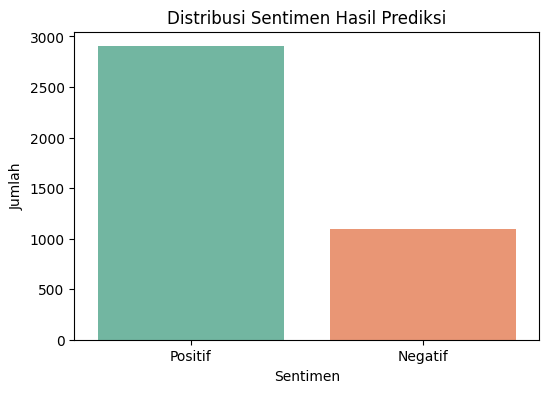

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Mapping 0/1 ke label string
label_map = {0: "Negatif", 1: "Positif"}
predicted_sentiment_df = pd.DataFrame(
    {'Prediksi_Sentimen': [label_map[val] for val in y_pred]},
    index=y_test.index
)

# Plot distribusi hasil prediksi
plt.figure(figsize=(6,4))
sns.countplot(x=predicted_sentiment_df['Prediksi_Sentimen'], palette="Set2")
plt.title("Distribusi Sentimen Hasil Prediksi")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah")
plt.show()

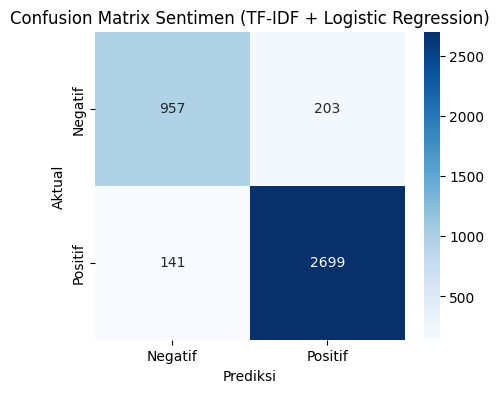

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Visualisasi dengan heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Negatif", "Positif"],
            yticklabels=["Negatif", "Positif"])
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix Sentimen (TF-IDF + Logistic Regression)")
plt.show()

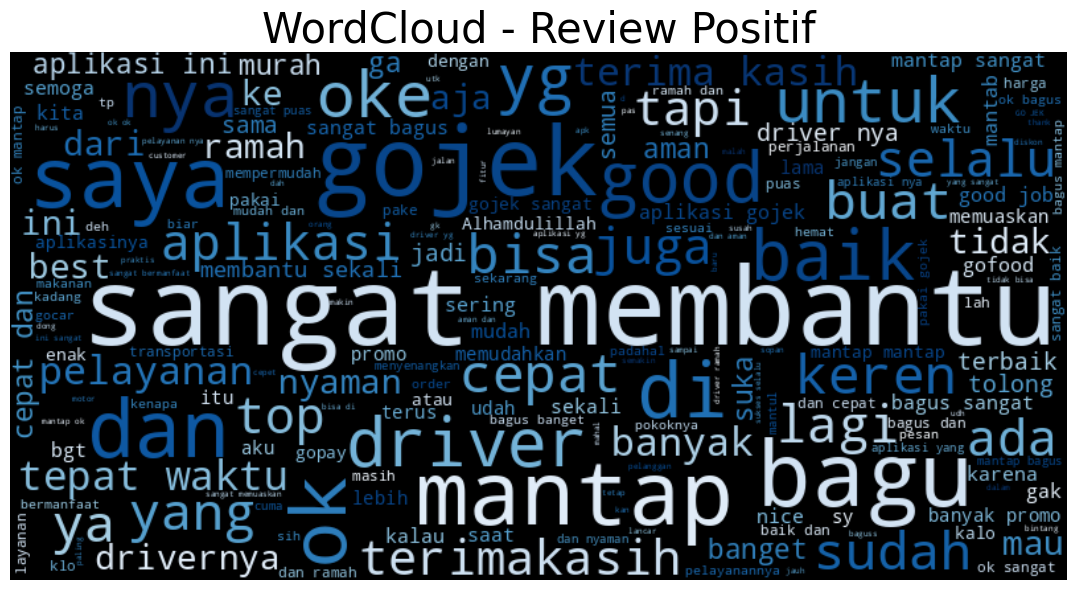

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Gabungkan teks berdasarkan sentimen
text_negatif = " ".join(df[df['Sentimen_Biner'] == 0]['Review Text'])
text_positif = " ".join(df[df['Sentimen_Biner'] == 1]['Review Text'])

# WordCloud untuk Positif
wordcloud_positif = WordCloud(width=800, height=400, background_color='black', colormap='Blues').generate(text_positif)

# Plot
plt.figure(figsize=(30,30))

plt.subplot(1,2,2)
plt.imshow(wordcloud_positif, interpolation='bilinear')
plt.title("WordCloud - Review Positif", fontsize=30)
plt.axis("off")

plt.show()

(np.float64(-0.5), np.float64(799.5), np.float64(399.5), np.float64(-0.5))

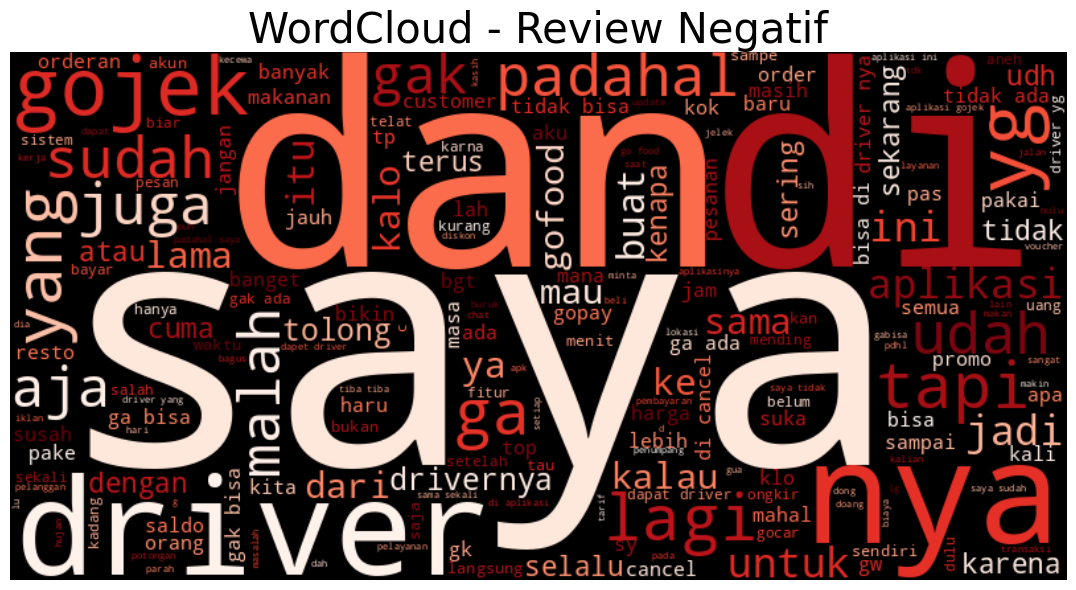

In [21]:
# WordCloud untuk Negatif
wordcloud_negatif = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(text_negatif)

# Plot
plt.figure(figsize=(30,30))

plt.subplot(1,2,1)
plt.imshow(wordcloud_negatif, interpolation='bilinear')
plt.title("WordCloud - Review Negatif", fontsize=30)
plt.axis("off")

In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D

# ======================================
# 1. Tokenisasi dan padding
# ======================================
max_words = 10000   # jumlah kata unik maksimum
max_len = 200       # panjang sequence maksimum

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_review'])

X_seq = tokenizer.texts_to_sequences(df['clean_review'])
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')

# Target
y = df['Sentimen_Biner']

# Split train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_pad, y, test_size=0.2, random_state=42, stratify=y
)

In [23]:
# ======================================
# 2. Model LSTM
# ======================================
model_lstm = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

print(model_lstm.summary())

# Training LSTM
history_lstm = model_lstm.fit(X_train, y_train,
                              epochs=5,
                              batch_size=32,
                              validation_data=(X_test, y_test))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 172s 340ms/step - accuracy: 0.7075 - loss: 0.6113 - val_accuracy: 0.7100 - val_loss: 0.6058
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 167s 333ms/step - accuracy: 0.7151 - loss: 0.6015 - val_accuracy: 0.7100 - val_loss: 0.6022
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 212s 353ms/step - accuracy: 0.7073 - loss: 0.6064 - val_accuracy: 0.7100 - val_loss: 0.6022
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 192s 332ms/step - accuracy: 0.7120 - loss: 0.6011 - val_accuracy: 0.7100 - val_loss: 0.6023
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 164s 327ms/step - accuracy: 0.7074 - loss: 0.6055 - val_accuracy: 0.7100 - val_loss: 0.6025


In [24]:
# ======================================
# 3. Model CNN
# ======================================
model_cnn = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_cnn.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

print(model_cnn.summary())

# Training CNN
history_cnn = model_cnn.fit(X_train, y_train,
                            epochs=5,
                            batch_size=32,
                            validation_data=(X_test, y_test))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 98ms/step - accuracy: 0.8343 - loss: 0.3871 - val_accuracy: 0.9220 - val_loss: 0.2088
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 48s 95ms/step - accuracy: 0.9375 - loss: 0.1800 - val_accuracy: 0.9225 - val_loss: 0.2062
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 86s 104ms/step - accuracy: 0.9621 - loss: 0.1162 - val_accuracy: 0.9162 - val_loss: 0.2435
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 100ms/step - accuracy: 0.9763 - loss: 0.0837 - val_accuracy: 0.9112 - val_loss: 0.2902
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 100ms/step - accuracy: 0.9819 - loss: 0.0643 - val_accuracy: 0.9110 - val_loss: 0.3348


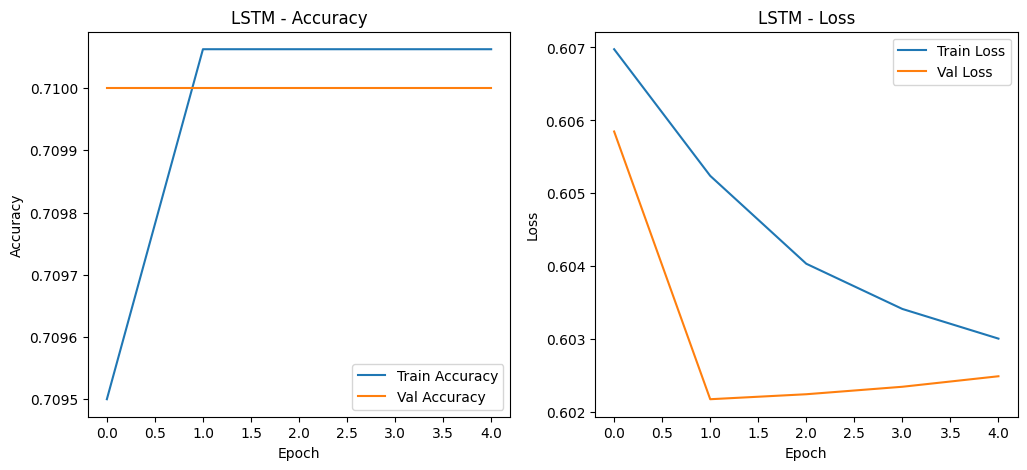

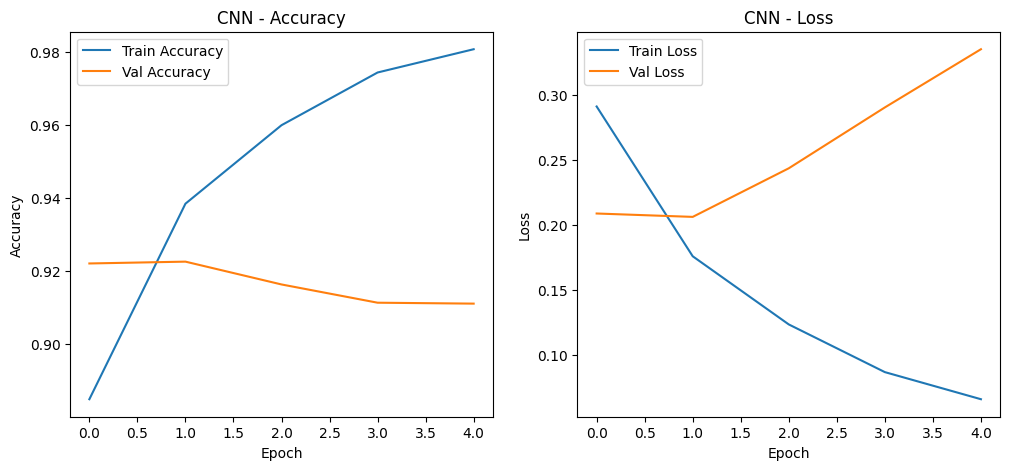

In [25]:
import matplotlib.pyplot as plt

# Fungsi untuk plot history
def plot_history(history, title):
    plt.figure(figsize=(12,5))

    # Plot akurasi
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot untuk LSTM
plot_history(history_lstm, "LSTM")

# Plot untuk CNN
plot_history(history_cnn, "CNN")

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step


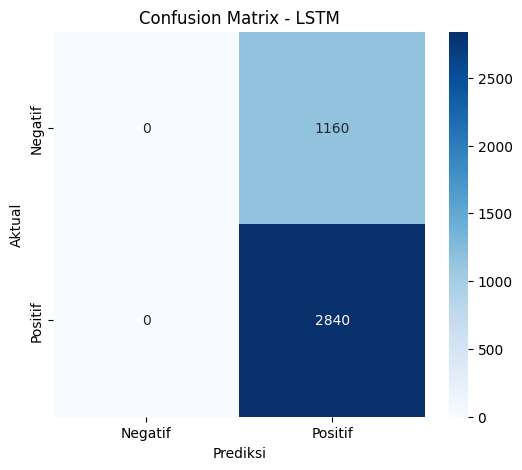

=== LSTM ===
              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00      1160
     Positif       0.71      1.00      0.83      2840

    accuracy                           0.71      4000
   macro avg       0.35      0.50      0.42      4000
weighted avg       0.50      0.71      0.59      4000

  1/125 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step


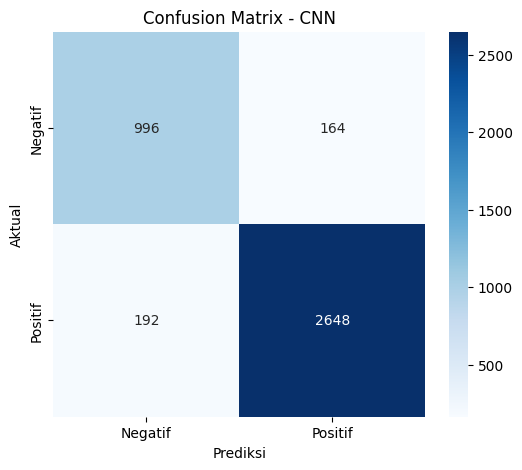

=== CNN ===
              precision    recall  f1-score   support

     Negatif       0.84      0.86      0.85      1160
     Positif       0.94      0.93      0.94      2840

    accuracy                           0.91      4000
   macro avg       0.89      0.90      0.89      4000
weighted avg       0.91      0.91      0.91      4000



In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ====== Confusion Matrix Function ======
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    labels = ["Negatif", "Positif"]

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Prediksi")
    plt.ylabel("Aktual")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

    print(f"=== {title} ===")
    print(classification_report(y_true, y_pred, target_names=labels))


# ====== Evaluasi LSTM ======
y_pred_lstm = (model_lstm.predict(X_test) > 0.5).astype("int32")
plot_confusion(y_test, y_pred_lstm, "LSTM")

# ====== Evaluasi CNN ======
y_pred_cnn = (model_cnn.predict(X_test) > 0.5).astype("int32")
plot_confusion(y_test, y_pred_cnn, "CNN")

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Prediksi LSTM
y_pred_lstm = (model_lstm.predict(X_test) > 0.5).astype("int32")
# Prediksi CNN
y_pred_cnn = (model_cnn.predict(X_test) > 0.5).astype("int32")

# Hitung metrik
results = {
    "Model": ["LSTM", "CNN"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lstm),
        accuracy_score(y_test, y_pred_cnn)
    ],
    "Precision": [
        precision_score(y_test, y_pred_lstm),
        precision_score(y_test, y_pred_cnn)
    ],
    "Recall": [
        recall_score(y_test, y_pred_lstm),
        recall_score(y_test, y_pred_cnn)
    ],
    "F1-Score": [
        f1_score(y_test, y_pred_lstm),
        f1_score(y_test, y_pred_cnn)
    ]
}

# Tampilkan tabel hasil
results_df = pd.DataFrame(results)
print(results_df)

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
  Model  Accuracy  Precision    Recall  F1-Score
0  LSTM     0.710   0.710000  1.000000  0.830409
1   CNN     0.911   0.941679  0.932394  0.937013


625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step


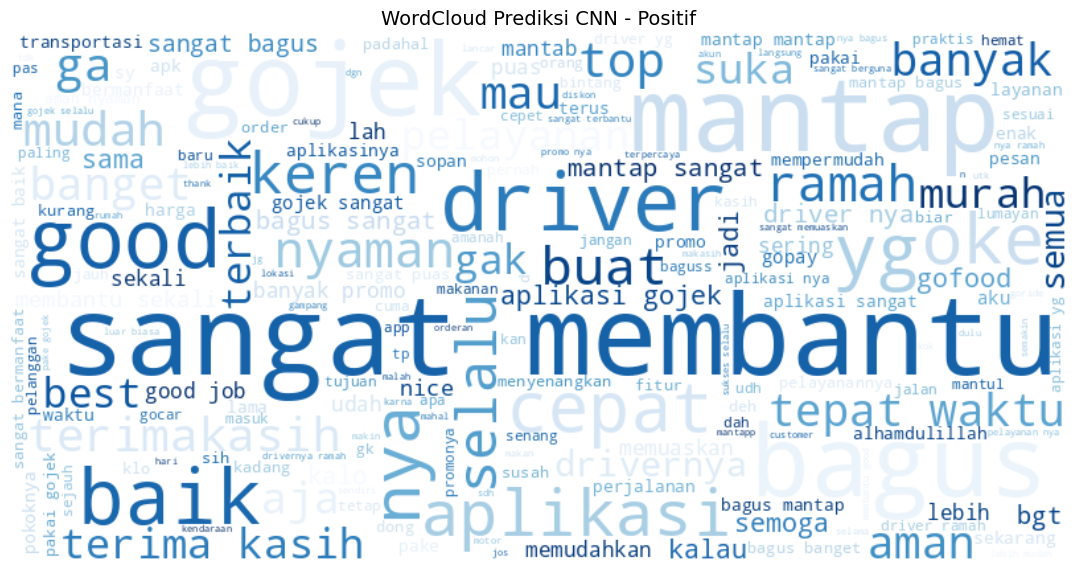

In [28]:
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# ============================
# Prediksi model CNN
# ============================
y_pred_cnn  = (model_cnn.predict(X_pad) > 0.5).astype(int).flatten()
df['Pred_CNN']  = y_pred_cnn

# ============================
# WordCloud berdasarkan CNN
# ============================
text_cnn_neg = " ".join(df[df['Pred_CNN'] == 0]['clean_review'])
text_cnn_pos = " ".join(df[df['Pred_CNN'] == 1]['clean_review'])

wordcloud_cnn_pos = WordCloud(width=800, height=400, background_color="white", colormap="Blues").generate(text_cnn_pos)

plt.figure(figsize=(30,30))
plt.subplot(1,2,2)
plt.imshow(wordcloud_cnn_pos, interpolation='bilinear')
plt.title("WordCloud Prediksi CNN - Positif", fontsize=14)
plt.axis("off")
plt.show()

(np.float64(-0.5), np.float64(799.5), np.float64(399.5), np.float64(-0.5))

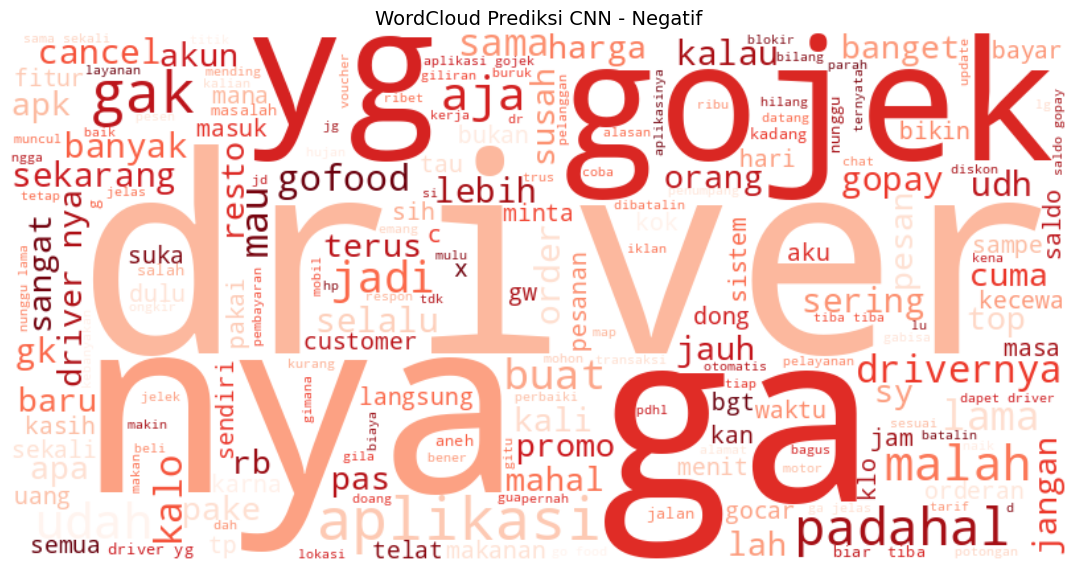

In [29]:
wordcloud_cnn_neg = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate(text_cnn_neg)

plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.imshow(wordcloud_cnn_neg, interpolation='bilinear')
plt.title("WordCloud Prediksi CNN - Negatif", fontsize=14)
plt.axis("off")